In [1]:
#pip install yellowbrick --user

In [2]:
import numpy as np

import pandas as pd
pd.options.display.max_columns = 100
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import colors

import seaborn as sns
sns.set_style('whitegrid')

import yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.style import set_palette

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv('data.csv', delimiter=';')
df.head()

,Номер варианта,ID,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,EMPL_TYPE,EMPL_SIZE,BANKACCOUNT_FLAG,Period_at_work,age,EMPL_PROPERTY,EMPL_FORM,FAMILY_STATUS,max90days,max60days,max30days,max21days,max14days,avg_num_delay,if_zalog,num_AccountActive180,num_AccountActive90,num_AccountActive60,Active_to_All_prc,numAccountActiveAll,numAccountClosed,sum_of_paym_months,all_credits,Active_not_cc,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
0,9,1000009,Форма банка (без печати работодателя),Покупка автомобиля,0.0,0.37,женский,0,0,среднее-специальное,вспомогательный персонал,>250,0.0,324.0,46.0,Транспорт,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,1000029,Поступление зарплаты на счет,Ремонт,1.0,0.49,женский,0,0,среднее-специальное,вспомогательный персонал,>=50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,1000049,2НДФЛ,Ремонт,1.0,0.24,женский,0,0,высшее,специалист,>250,0.0,35.0,25.0,Финансы,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,1000069,Поступление зарплаты на счет,Другое,1.0,0.26,мужской,0,0,высшее,специалист,>250,1.0,26.0,37.0,Финансы,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,1000089,Форма банка (без печати работодателя),Покупка автомобиля,1.0,0.43,мужской,0,0,Высшее/Второе высшее/Ученая степень,вспомогательный персонал,>250,0.0,56.0,31.0,Другое,Государственное предприятие,холост / не замужем,0.0,0.0,0.0,0.0,0.0,0.023333,1.0,0.0,0.0,0.0,0.5,5.0,5.0,293.0,10.0,1.0,3.0,27.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Разведочный анализ данных

In [4]:
df.shape

(10243, 44)

In [5]:
print('Количество уникальных клиентов:', len(pd.unique(df.ID)))

Количество уникальных клиентов: 10243


In [6]:
df.drop(columns=['Номер варианта', 'ID'], axis=1, inplace=True)

In [7]:
df.dtypes

INCOME_BASE_TYPE          object
CREDIT_PURPOSE            object
INSURANCE_FLAG           float64
DTI                      float64
SEX                       object
FULL_AGE_CHILD_NUMBER      int64
DEPENDANT_NUMBER           int64
EDUCATION                 object
EMPL_TYPE                 object
EMPL_SIZE                 object
BANKACCOUNT_FLAG         float64
Period_at_work           float64
age                      float64
EMPL_PROPERTY             object
EMPL_FORM                 object
FAMILY_STATUS             object
max90days                float64
max60days                float64
max30days                float64
max21days                float64
max14days                float64
avg_num_delay            float64
if_zalog                 float64
num_AccountActive180     float64
num_AccountActive90      float64
num_AccountActive60      float64
Active_to_All_prc        float64
numAccountActiveAll      float64
numAccountClosed         float64
sum_of_paym_months       float64
all_credit

In [8]:
# непрерывные
num_feat = ['DTI', 'FULL_AGE_CHILD_NUMBER', 'DEPENDANT_NUMBER', 'Period_at_work', 'age',
            'max90days', 'max60days', 'max30days', 'max21days', 'max14days', 'avg_num_delay',
            'num_AccountActive180', 'num_AccountActive90', 'num_AccountActive60', 'Active_to_All_prc',
            'numAccountActiveAll', 'numAccountClosed', 'sum_of_paym_months', 'all_credits', 'Active_not_cc',
            'own_closed', 'min_MnthAfterLoan', 'max_MnthAfterLoan']

# категориальные
cat_feat = list(set(df.columns) - set(num_feat))

In [9]:
len(set(num_feat + cat_feat)) == df.shape[1]

True

In [10]:
def describe_cat_feat(df, features):    
    unique_values = [list(pd.unique(df[f'{i}'])) for i in df[features].columns]
    lengths = list(map(len, unique_values))
    unique_values = [(', ').join(sorted(map(str, unique_values[i]))) for i in range(len(unique_values))]

    cat_description = pd.DataFrame(dict(zip(df[features].columns, unique_values)), index=[0]).T
    cat_description.columns = ['Уникальные значения']
    cat_description['Число уникальных значений'] = lengths

    return cat_description

describe_cat_feat(df, cat_feat)

,Уникальные значения,Число уникальных значений
EMPL_FORM,"nan, Государственное предприятие, ЗАО, Иная форма, Индивидуальный предприниматель, ОАО, ООО",7
if_zalog,"0.0, 1.0, nan",3
EMPL_TYPE,"nan, вспомогательный персонал, другое, менеджер высшего звена, менеджер по продажам, менеджер среднего звена, рабочий, специалист, страховой агент, торговый представитель",10
thirty_vintage,"0.0, 1.0, nan",3
EDUCATION,"*n.a.*, nan, Высшее/Второе высшее/Ученая степень, Неполное среднее, второе высшее, высшее, незаконченное высшее, среднее, среднее-специальное, ученая степень",10
thirty_in_a_year,"0.0, 1.0, nan",3
BANKACCOUNT_FLAG,"0.0, 1.0, 3.0, 4.0, nan",5
FAMILY_STATUS,"nan, вдовец / вдова, гражданский брак, женат / замужем, повторный брак, разведен / разведена, холост / не замужем",7
CREDIT_PURPOSE,"Другое, Лечение, Обучение, Отпуск, Покупка автомобиля, Покупка бытовой техники, Покупка земли, Покупка мебели, Покупка недвижимости/ строительство, Ремонт",10
EMPL_PROPERTY,"nan, Государственная служба, Другое, Информационные технологии, Наука, Производство, Сельское и лесное хозяйство, Строительство, Торговля, Транспорт, Туризм, Финансы, Юридические услуги",13


In [11]:
def standartize_na(df, feature):
    df[f'{feature}'] = np.where(df[f'{feature}'] == '*n.a.*', None, df[f'{feature}'])
    return df

df = standartize_na(standartize_na(df, 'EDUCATION'), 'EMPL_SIZE')

In [12]:
describe_cat_feat(df, cat_feat)['Число уникальных значений'].sum() - len(cat_feat)

86

In [13]:
def get_na(df):
    nans = pd.DataFrame({'Количество пропусков' : df.isna().sum(),
                         '% пропусков' : df.isna().sum() / len(df) * 100})
    return nans

(get_na(df).style.background_gradient(subset=['Количество пропусков'], cmap='Reds')
 .format('{:.1f}%', subset='% пропусков'))

,Количество пропусков,% пропусков
INCOME_BASE_TYPE,78,0.8%
CREDIT_PURPOSE,0,0.0%
INSURANCE_FLAG,1,0.0%
DTI,125,1.2%
SEX,0,0.0%
FULL_AGE_CHILD_NUMBER,0,0.0%
DEPENDANT_NUMBER,0,0.0%
EDUCATION,26,0.3%
EMPL_TYPE,12,0.1%
EMPL_SIZE,124,1.2%


In [14]:
nans_structure = pd.DataFrame([(i / df.shape[1] * 100, len(df[df.isna().sum(axis=1)==i]) / len(df) * 100)
                               for i in range(df.isna().sum(axis=1).max()+1)
                               if len(df[df.isna().sum(axis=1)==i]) != 0],
                              columns=['% пропусков в строке',
                                       '% таких строк в датасете'])

(nans_structure.style.background_gradient(subset=['% таких строк в датасете'], cmap='Reds')
 .format('{:.1f}%'))

,% пропусков в строке,% таких строк в датасете
0,0.0%,35.6%
1,2.4%,0.2%
2,4.8%,0.0%
3,11.9%,0.1%
4,50.0%,2.7%
5,61.9%,0.5%
6,66.7%,36.9%
7,69.0%,0.1%
8,71.4%,0.4%
9,73.8%,0.7%


In [15]:
df[df.isna().sum(axis=1) ==
   np.round(nans_structure.loc[6]['% пропусков в строке'] / 100 * df.shape[1])].sample(10)

,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,EMPL_TYPE,EMPL_SIZE,BANKACCOUNT_FLAG,Period_at_work,age,EMPL_PROPERTY,EMPL_FORM,FAMILY_STATUS,max90days,max60days,max30days,max21days,max14days,avg_num_delay,if_zalog,num_AccountActive180,num_AccountActive90,num_AccountActive60,Active_to_All_prc,numAccountActiveAll,numAccountClosed,sum_of_paym_months,all_credits,Active_not_cc,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
5821,Форма банка (без печати работодателя),Отпуск,0.0,0.18,мужской,0,0,высшее,менеджер среднего звена,>250,0.0,49.0,24.0,Наука,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5912,Форма банка (без печати работодателя),Ремонт,0.0,0.38,женский,0,0,высшее,менеджер среднего звена,>250,0.0,38.0,31.0,Финансы,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
336,Свободная форма с печатью работодателя,Ремонт,1.0,0.45,мужской,1,0,Высшее/Второе высшее/Ученая степень,менеджер высшего звена,>250,0.0,74.0,36.0,Строительство,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4908,Форма банка (без печати работодателя),Другое,1.0,0.02,мужской,2,0,высшее,менеджер высшего звена,< 50,0.0,33.0,42.0,Строительство,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6415,2НДФЛ,Покупка недвижимости/ строительство,1.0,0.21,женский,0,0,высшее,специалист,>250,0.0,390.0,51.0,Наука,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2461,Форма банка (без печати работодателя),Ремонт,1.0,0.26,мужской,0,0,среднее-специальное,рабочий,>250,0.0,135.0,49.0,Строительство,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2892,Форма банка (без печати работодателя),Ремонт,1.0,0.14,женский,2,0,среднее-специальное,специалист,< 50,0.0,115.0,36.0,Наука,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5007,Поступление зарплаты на счет,Покупка автомобиля,0.0,0.54,мужской,0,0,высшее,специалист,>250,1.0,12.0,26.0,Производство,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9801,2НДФЛ,Ремонт,1.0,0.27,женский,0,0,среднее,рабочий,>250,0.0,22.0,52.0,Производство,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6949,Свободная форма с печатью работодателя,Ремонт,1.0,0.31,женский,0,0,незаконченное высшее,менеджер среднего звена,< 50,3.0,133.0,47.0,Строительство,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df[df.isna().sum(axis=1) ==
   np.round(nans_structure.loc[10]['% пропусков в строке'] / 100 * df.shape[1])].sample(10)

,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,EMPL_TYPE,EMPL_SIZE,BANKACCOUNT_FLAG,Period_at_work,age,EMPL_PROPERTY,EMPL_FORM,FAMILY_STATUS,max90days,max60days,max30days,max21days,max14days,avg_num_delay,if_zalog,num_AccountActive180,num_AccountActive90,num_AccountActive60,Active_to_All_prc,numAccountActiveAll,numAccountClosed,sum_of_paym_months,all_credits,Active_not_cc,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
2584,Форма банка (без печати работодателя),Ремонт,1.0,0.16,женский,0,0,Высшее/Второе высшее/Ученая степень,вспомогательный персонал,>=100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417,Форма банка (без печати работодателя),Покупка недвижимости/ строительство,1.0,0.52,мужской,2,0,высшее,менеджер по продажам,>=200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5652,Форма банка (без печати работодателя),Ремонт,1.0,0.11,мужской,2,0,Высшее/Второе высшее/Ученая степень,рабочий,>=50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
210,Форма банка (без печати работодателя),Ремонт,0.0,0.35,женский,0,0,высшее,специалист,>100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8483,2НДФЛ,Ремонт,0.0,0.43,женский,0,0,второе высшее,менеджер высшего звена,>=200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9335,2НДФЛ,Ремонт,0.0,0.52,женский,0,0,Высшее/Второе высшее/Ученая степень,менеджер среднего звена,>=50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1515,Поступление зарплаты на счет,Ремонт,0.0,0.52,женский,0,0,среднее-специальное,специалист,>100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8851,Форма банка (без печати работодателя),Ремонт,1.0,0.45,мужской,1,0,высшее,специалист,>100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1327,Поступление зарплаты на счет,Покупка бытовой техники,1.0,0.46,женский,1,0,высшее,менеджер среднего звена,>=50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362,Поступление зарплаты на счет,Покупка недвижимости/ строительство,1.0,0.31,женский,1,0,среднее-специальное,вспомогательный персонал,>=200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_without_new = df[df.isna().sum(axis=1) <=
        np.round(nans_structure.loc[0]['% пропусков в строке'] / 100 * df.shape[1])]

df_without_new.shape

(3649, 42)

In [18]:
def get_zeros(df):
    zeros = pd.DataFrame({'Количество нулей' : [df==0][0].sum(),
                          '% нулей' : [df==0][0].sum() / len(df) * 100})
    return zeros

def transform_zeros(df, feature):
    df[f'{feature}'] = np.where(df[f'{feature}'] == 0, '-', df[f'{feature}'])
    return df

In [19]:
def remove_columns(df, names, num, cat, threshold):
    df.drop(columns=names, axis=1, inplace=True)

    num = list(set(num) - set(names[:threshold]))
    cat = list(set(cat) - set(names[threshold:]))

    status = 'OK' if len(num) + len(cat) == df.shape[1] else 'Not OK'
         
    return status, num, cat

In [20]:
(get_na(df_without_new).style.background_gradient(subset=['Количество пропусков'], cmap='Reds')
 .format('{:.1f}%', subset='% пропусков'))

,Количество пропусков,% пропусков
INCOME_BASE_TYPE,0,0.0%
CREDIT_PURPOSE,0,0.0%
INSURANCE_FLAG,0,0.0%
DTI,0,0.0%
SEX,0,0.0%
FULL_AGE_CHILD_NUMBER,0,0.0%
DEPENDANT_NUMBER,0,0.0%
EDUCATION,0,0.0%
EMPL_TYPE,0,0.0%
EMPL_SIZE,0,0.0%


In [21]:
df_without_new.isna().sum().sum()

0

In [22]:
(get_zeros(df_without_new).style.background_gradient(subset=['Количество нулей'], cmap='Reds')
 .format('{:.1f}%', subset='% нулей'))

,Количество нулей,% нулей
INCOME_BASE_TYPE,0,0.0%
CREDIT_PURPOSE,0,0.0%
INSURANCE_FLAG,1386,38.0%
DTI,0,0.0%
SEX,0,0.0%
FULL_AGE_CHILD_NUMBER,2246,61.6%
DEPENDANT_NUMBER,3636,99.6%
EDUCATION,0,0.0%
EMPL_TYPE,0,0.0%
EMPL_SIZE,0,0.0%


In [23]:
lack_info_old = ['DEPENDANT_NUMBER', 'num_AccountActive60',
                 'sixty_in_a_year', 'ninety_in_a_year',
                 'thirty_vintage', 'sixty_vintage', 'ninety_vintage']

In [24]:
old = remove_columns(df_without_new, lack_info_old, num_feat, cat_feat, 2)
num_feat_old, cat_feat_old = old[1], old[2]

In [25]:
stats_old = df_without_new[num_feat_old].agg(['describe']).T
(stats_old.style.background_gradient(subset=['mean', 'min', '25%', '50%', '75%', 'max'], axis=1, cmap='Blues')
 .format('{:.2f}'))

,,count,mean,std,min,25%,50%,75%,max
max_MnthAfterLoan,describe,3649.00,61.54,30.57,0.00,34.00,68.00,87.00,179.00
max14days,describe,3649.00,0.45,0.90,0.00,0.00,0.00,1.00,10.00
DTI,describe,3649.00,0.39,0.14,0.01,0.29,0.41,0.49,0.62
Period_at_work,describe,3649.00,56.00,53.30,6.00,18.00,40.00,77.00,422.00
own_closed,describe,3649.00,0.72,1.11,0.00,0.00,0.00,1.00,11.00
max30days,describe,3649.00,0.77,1.21,0.00,0.00,0.00,1.00,12.00
Active_to_All_prc,describe,3649.00,0.41,0.29,0.00,0.20,0.38,0.57,1.00
num_AccountActive90,describe,3649.00,0.16,0.43,0.00,0.00,0.00,0.00,3.00
max90days,describe,3649.00,1.57,1.85,0.00,0.00,1.00,2.00,25.00
FULL_AGE_CHILD_NUMBER,describe,3649.00,0.53,0.76,0.00,0.00,0.00,1.00,4.00


In [26]:
df, num_feat, cat_feat = df_without_new, num_feat_old, cat_feat_old

In [27]:
len(df[df.min_MnthAfterLoan == -1])

11

In [28]:
(df[num_feat] < 0).sum().sum()

11

In [29]:
df = df[df.min_MnthAfterLoan > -1]

In [30]:
len(df[df.max_MnthAfterLoan - df.min_MnthAfterLoan < 0])

0

In [31]:
len(df[df.numAccountActiveAll - df.num_AccountActive180 < 0])

0

In [32]:
l = np.array([14, 21, 30, 60, 90])
u = l
m = np.meshgrid(l, u)
cnt = 0

for i in range(len(l)):
    for j in range(len(u)):
        if (m[0] - m[1] > 0)[i,j] == True:
            error = len(df[df[f'max{m[0][i,j]}days'] - df[f'max{m[1][i,j]}days'] < 0])
            if error > 0:
                print(m[0][i,j], m[1][i,j], error)
            else:
                cnt += 1

if cnt == (m[0] - m[1] > 0).sum():
    print('Ошибок нет')

Ошибок нет


In [33]:
np.round((df.age - df.max_MnthAfterLoan / 12).min(), 2)

15.08

In [34]:
df[df.age - df.max_MnthAfterLoan / 12 < 18]

,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,EDUCATION,EMPL_TYPE,EMPL_SIZE,BANKACCOUNT_FLAG,Period_at_work,age,EMPL_PROPERTY,EMPL_FORM,FAMILY_STATUS,max90days,max60days,max30days,max21days,max14days,avg_num_delay,if_zalog,num_AccountActive180,num_AccountActive90,Active_to_All_prc,numAccountActiveAll,numAccountClosed,sum_of_paym_months,all_credits,Active_not_cc,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year
192,Поступление зарплаты на счет,Покупка автомобиля,1.0,0.26,мужской,0,высшее,специалист,>250,0.0,22.0,26.0,Торговля,ООО,холост / не замужем,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0,6.0,1.0,0.0,0.0,100.0,100.0,0.0,0.0
1820,Поступление зарплаты на счет,Ремонт,1.0,0.47,женский,0,высшее,специалист,>250,0.0,31.0,25.0,Другое,Иная форма,холост / не замужем,2.0,2.0,0.0,0.0,0.0,0.032258,0.0,1.0,1.0,0.333333,2.0,4.0,60.0,6.0,1.0,2.0,1.0,86.0,1.0,0.0
4683,Поступление зарплаты на счет,Ремонт,1.0,0.26,женский,1,высшее,менеджер среднего звена,>250,0.0,12.0,26.0,Торговля,ООО,женат / замужем,5.0,4.0,3.0,2.0,1.0,0.107143,1.0,3.0,3.0,0.400000,4.0,6.0,50.0,10.0,3.0,0.0,0.0,102.0,1.0,1.0
4685,Поступление зарплаты на счет,Отпуск,1.0,0.46,женский,0,высшее,вспомогательный персонал,< 50,0.0,10.0,23.0,Торговля,ОАО,холост / не замужем,1.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,4.0,20.0,4.0,0.0,0.0,6.0,65.0,0.0,0.0
6185,Свободная форма с печатью работодателя,Покупка автомобиля,0.0,0.38,мужской,0,высшее,вспомогательный персонал,>250,0.0,19.0,25.0,Торговля,ООО,женат / замужем,0.0,0.0,0.0,0.0,0.0,0.355556,0.0,2.0,0.0,0.400000,2.0,3.0,29.0,5.0,1.0,0.0,5.0,86.0,1.0,1.0
6459,Форма банка (без печати работодателя),Другое,0.0,0.22,мужской,2,среднее-специальное,специалист,>250,0.0,83.0,30.0,Торговля,ЗАО,женат / замужем,0.0,0.0,0.0,0.0,0.0,0.102151,0.0,0.0,0.0,0.428571,3.0,4.0,167.0,7.0,2.0,0.0,36.0,179.0,1.0,1.0


In [35]:
color = sns.color_palette('Paired')[0]

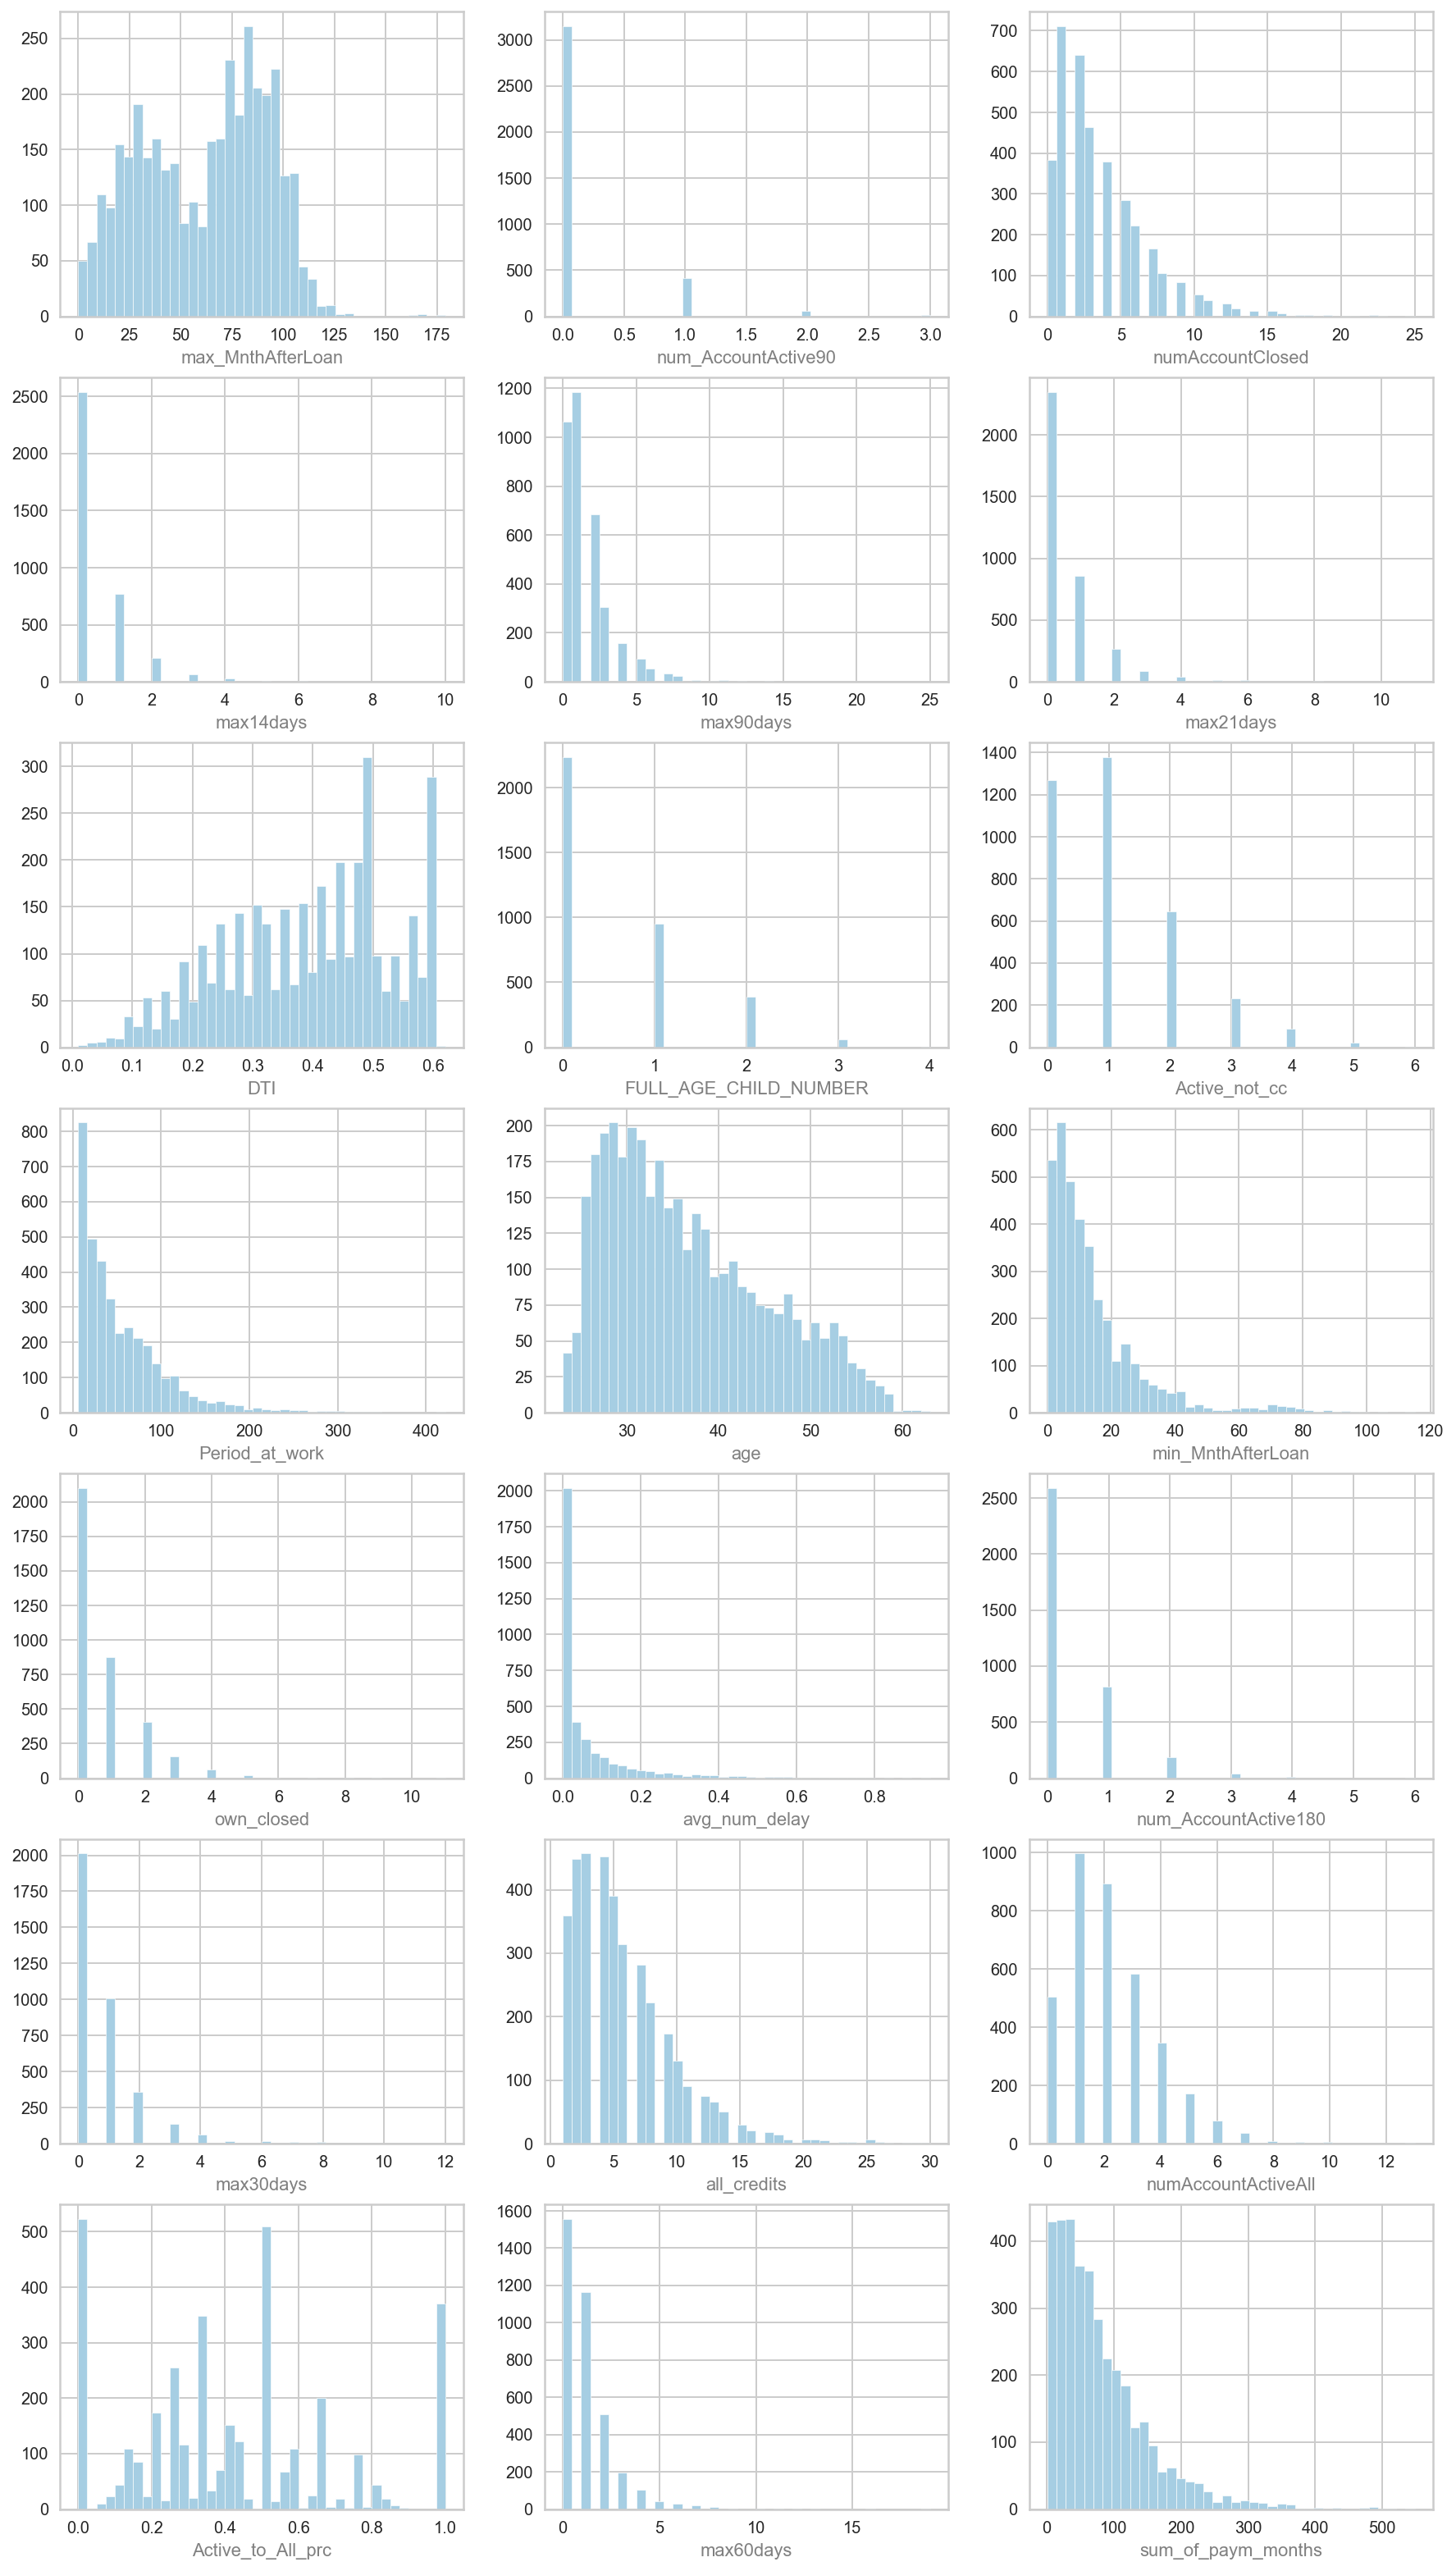

In [36]:
def plot_hists(df, r, c, features):
    fig, axs = plt.subplots(r, c, figsize=(c*5, r*4))

    rows = np.arange(r)
    columns = np.arange(c)
    coords = np.meshgrid(rows, columns)
    
    for (i, j, k) in list(zip(coords[0].ravel(), coords[1].ravel(), features)):
        column = df[f'{k}']
        axs[i, j].hist(column, bins=40, color=color)
        axs[i, j].set_xlabel(k, color='grey')
        
plot_hists(df, 7, 3, num_feat)  

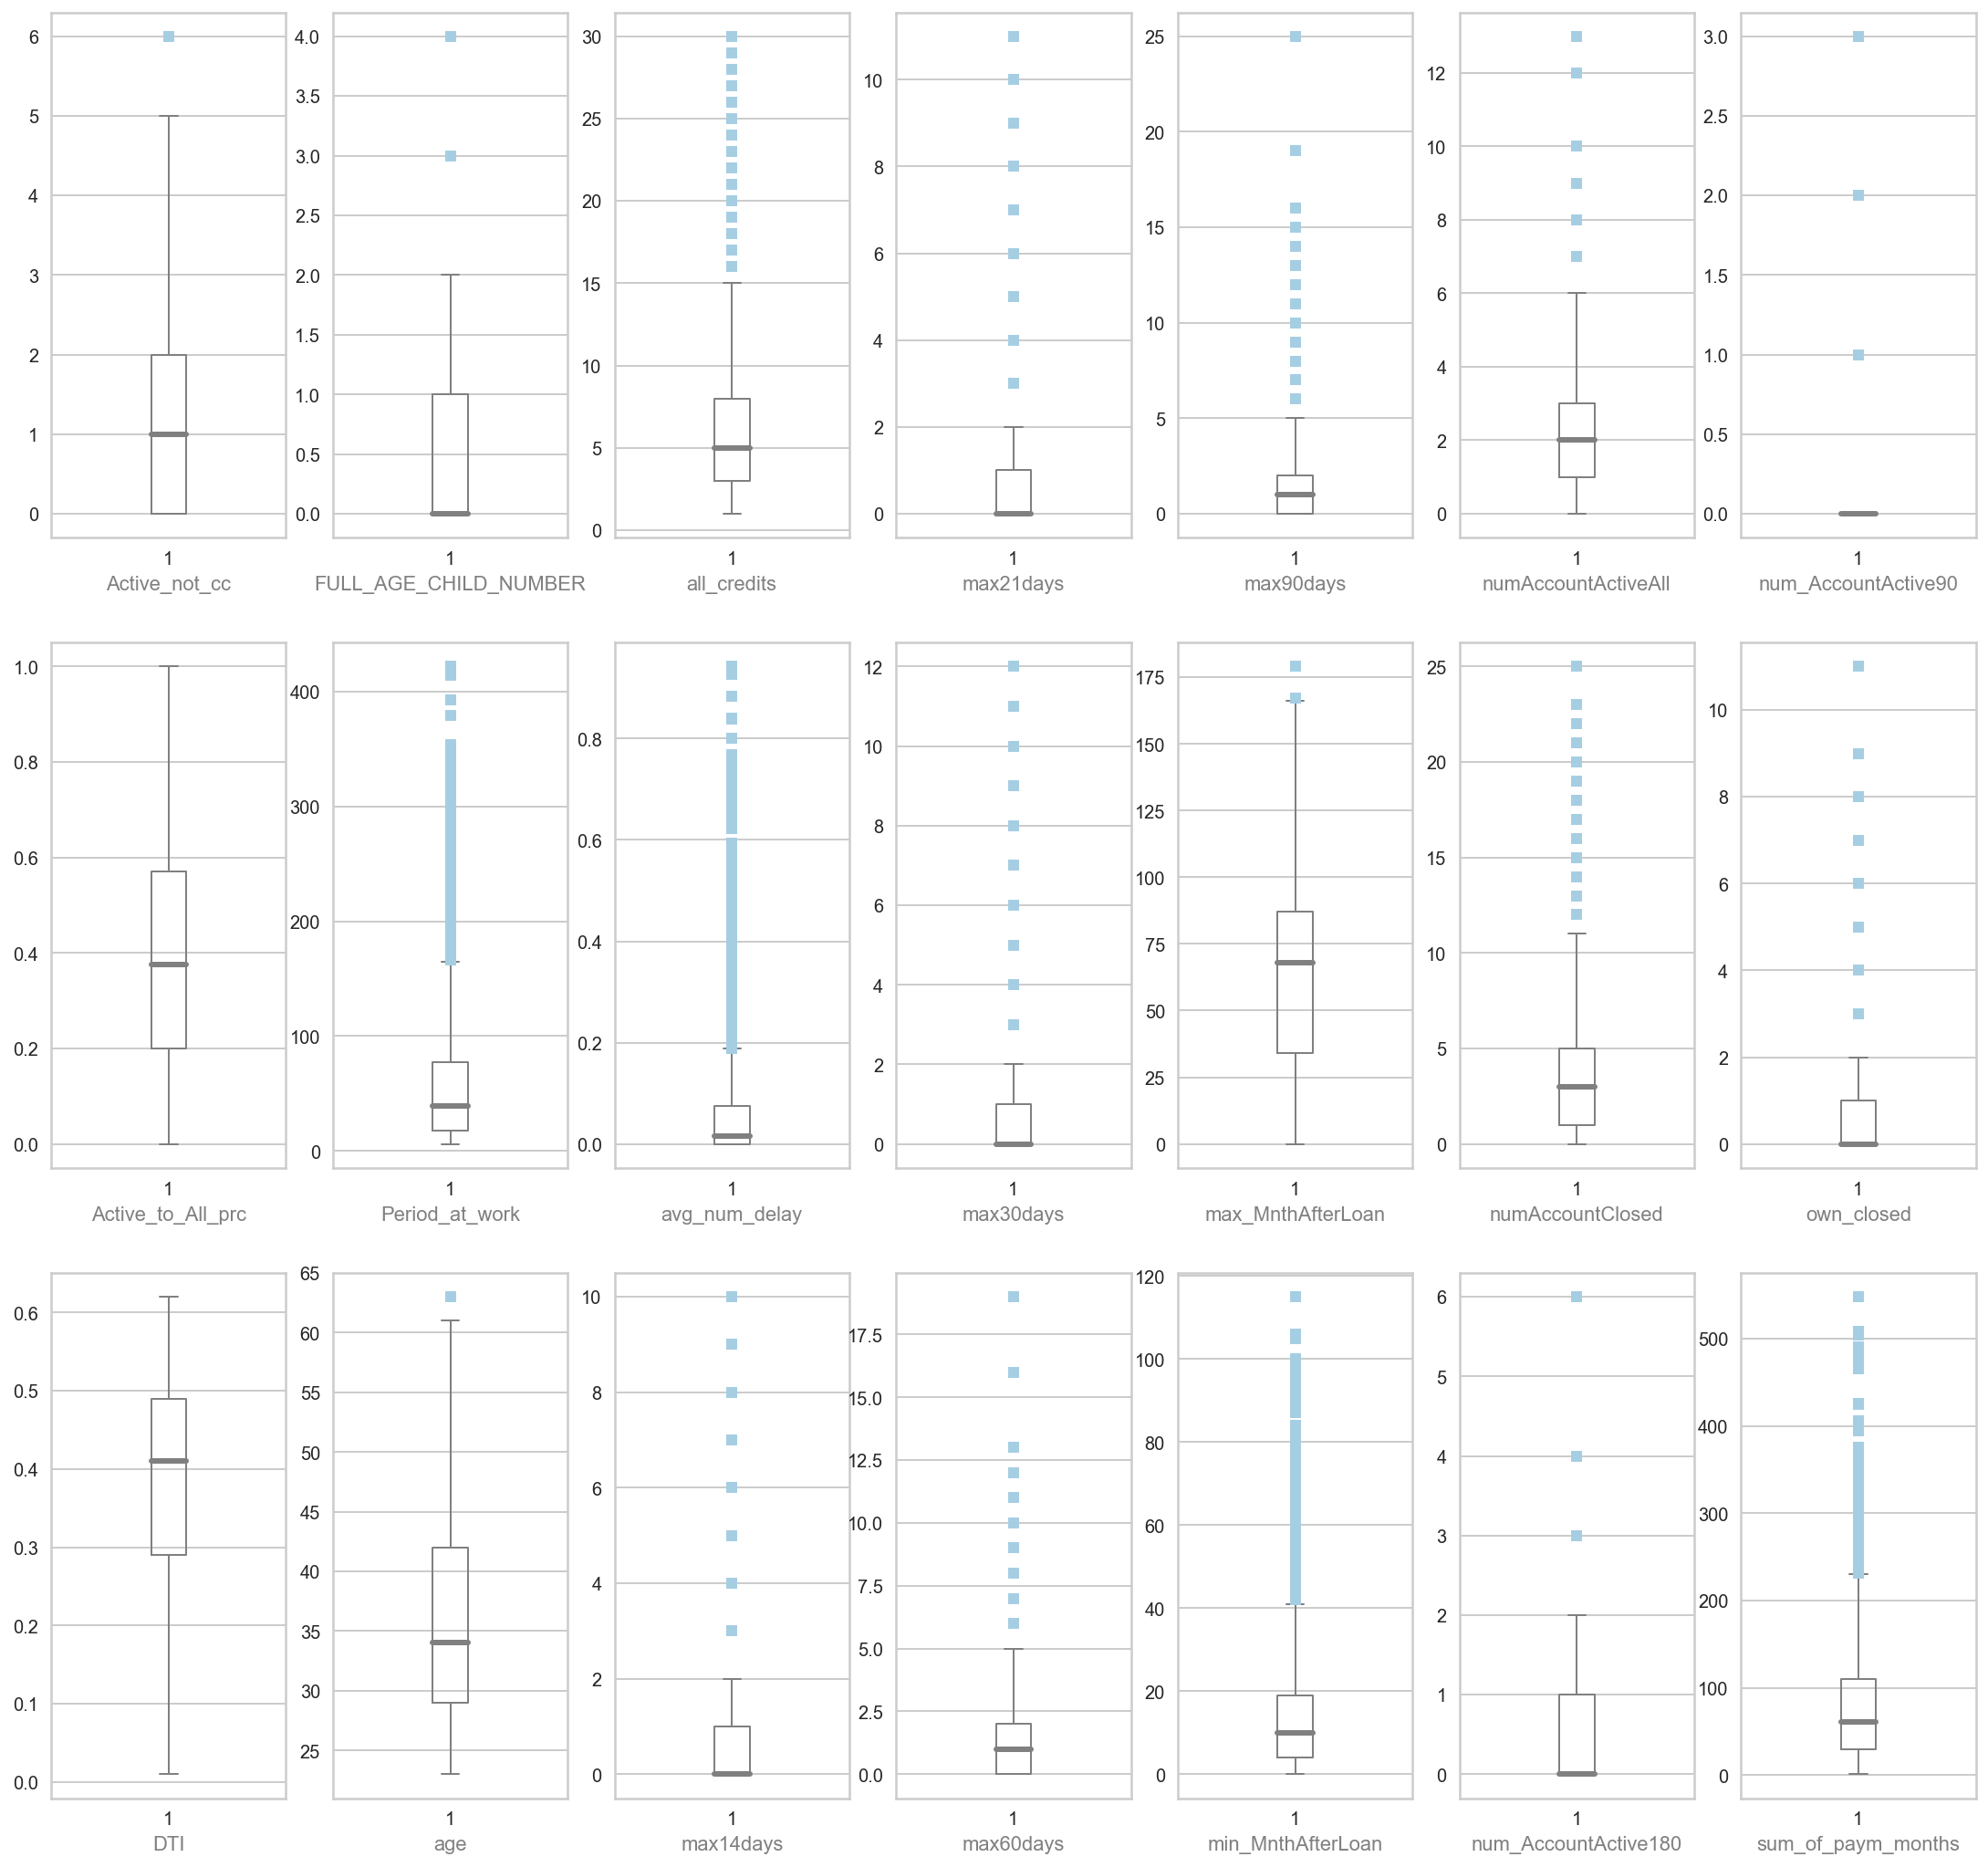

In [37]:
def plot_boxplots(df, r, c, features):
    fig, axs = plt.subplots(r, c, figsize=(c*2.7, r*6))

    rows = np.arange(r)
    columns = np.arange(c)
    coords = np.meshgrid(rows, columns)
    
    flierprops = dict(marker='s', markerfacecolor=color, markeredgecolor='none')
    medianprops = dict(color='grey', linewidth=3)
    edgeprops = dict(color='grey')
    
    for (i, j, k) in list(zip(coords[0].ravel(), coords[1].ravel(), features)):
        column = df[f'{k}']
        axs[i, j].boxplot(column,
                          flierprops=flierprops,
                          medianprops=medianprops,
                          boxprops=edgeprops,
                          whiskerprops=edgeprops,
                          capprops=edgeprops)
        axs[i, j].set_xlabel(k, color='grey')
        axs[i, j].grid(visible=False, axis='x', which='both')
        
plot_boxplots(df, 3, 7, sorted(num_feat))

In [38]:
df = df[(df.age <= 61) &
        (df.num_AccountActive90 <= 1) &
        (df.max_MnthAfterLoan <= 160) &
        (df.num_AccountActive180 <= 2) &
        (df.FULL_AGE_CHILD_NUMBER <= 2) &
        (df.Active_not_cc <= 5)]

In [39]:
df.shape

(3471, 35)

In [40]:
stats = df[num_feat].agg(['describe']).T
(stats.style.background_gradient(subset=['mean', 'min', '25%', '50%', '75%', 'max'], axis=1, cmap='Blues')
 .format('{:.2f}'))

,,count,mean,std,min,25%,50%,75%,max
max_MnthAfterLoan,describe,3471.00,61.20,30.37,0.00,34.00,67.00,87.00,131.00
max14days,describe,3471.00,0.45,0.89,0.00,0.00,0.00,1.00,10.00
DTI,describe,3471.00,0.39,0.14,0.01,0.28,0.41,0.49,0.59
Period_at_work,describe,3471.00,55.54,52.91,6.00,18.00,39.00,76.50,422.00
own_closed,describe,3471.00,0.71,1.08,0.00,0.00,0.00,1.00,9.00
max30days,describe,3471.00,0.74,1.17,0.00,0.00,0.00,1.00,11.00
Active_to_All_prc,describe,3471.00,0.41,0.29,0.00,0.20,0.38,0.57,1.00
num_AccountActive90,describe,3471.00,0.11,0.32,0.00,0.00,0.00,0.00,1.00
max90days,describe,3471.00,1.50,1.75,0.00,0.00,1.00,2.00,25.00
FULL_AGE_CHILD_NUMBER,describe,3471.00,0.48,0.68,0.00,0.00,0.00,1.00,2.00


In [41]:
def convert_feature(df, feature):
    df[f'{feature}'] = np.where(df[f'{feature}'] >= 1, 1, 0)
    return df

new_cat = ['max14days', 'max21days', 'FULL_AGE_CHILD_NUMBER', 'own_closed', 'num_AccountActive180', 'max30days']
for i in new_cat:
    df = convert_feature(df, i)

In [42]:
cat_feat = cat_feat + new_cat + ['num_AccountActive90']
for i in new_cat:
    num_feat.remove(i)
num_feat.remove('num_AccountActive90')

len(num_feat) + len(cat_feat) == df.shape[1]

True

In [43]:
def plot_barcharts(n, indx, df, features):   
    fig, axs = plt.subplots(n, figsize=(7, n*4.5))
    
    for (i, feature) in list(zip(range(n), features)):
        df_group = df.groupby(feature).count()['numAccountActiveAll']

        if indx == 'float':
            opts = list(map(int, list(df_group.index)))
        else:
            opts = list(df_group.index)

        freq = df_group / sum(df_group) * 100
        y_pos = np.arange(len(opts))

        axs[i].barh(y_pos, freq, color=color, align='center')
        
        for u, v in enumerate(freq):
            axs[i].text(v + 2, u + 0.15, str(round(v, 2))+'%', color=color, fontweight='bold')
        
        axs[i].set_yticks(y_pos)
        axs[i].set_yticklabels(opts)
        axs[i].invert_yaxis()
        axs[i].set_xlim(0, 100)
        axs[i].set_xlabel('% of values', color='grey')
        axs[i].set_ylabel(feature, color='grey')
        axs[i].grid(color='whitesmoke')

    plt.show()

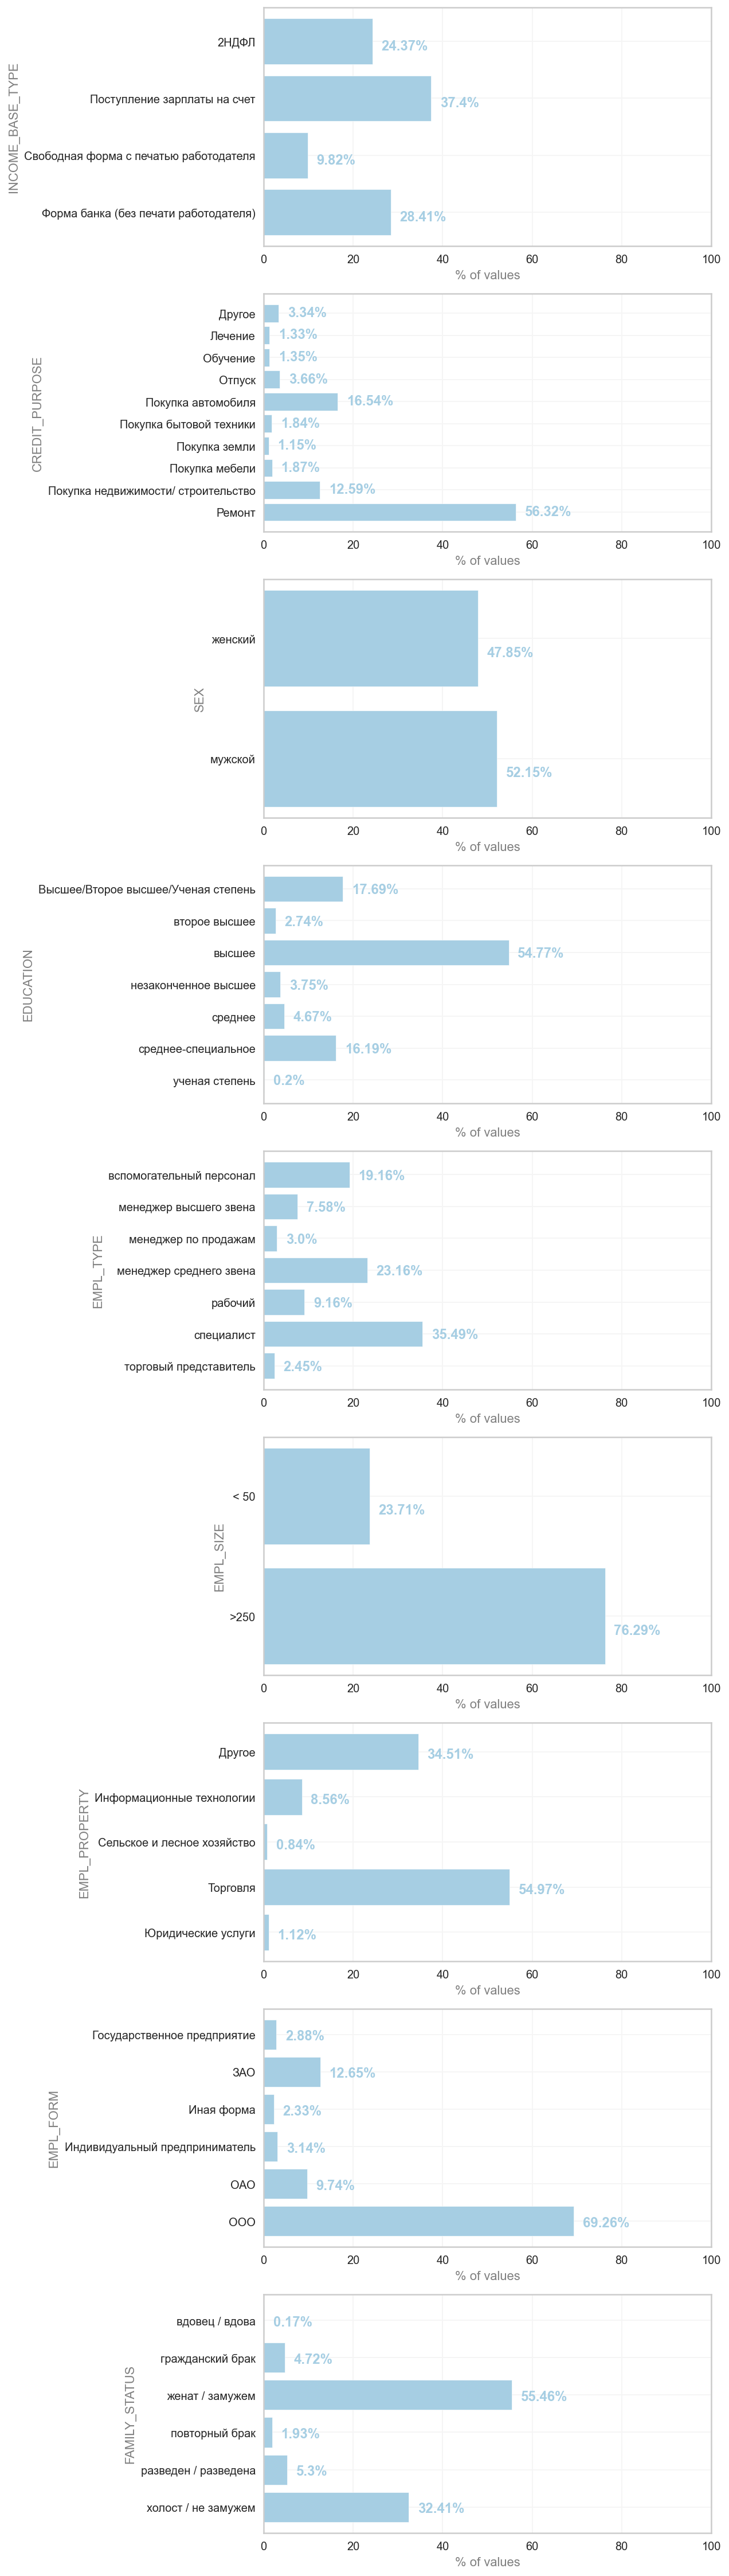

In [44]:
str_feat = ['INCOME_BASE_TYPE', 'CREDIT_PURPOSE', 'SEX',
            'EDUCATION', 'EMPL_TYPE', 'EMPL_SIZE',
            'EMPL_PROPERTY', 'EMPL_FORM', 'FAMILY_STATUS']

plot_barcharts(len(str_feat), 'str', df, str_feat)

In [45]:
# Цель кредита
df.CREDIT_PURPOSE = np.where(((df.CREDIT_PURPOSE=='Лечение') |
                              (df.CREDIT_PURPOSE=='Обучение') |
                              (df.CREDIT_PURPOSE=='Отпуск')), 'Нематериальные нужды',
                             
                             np.where(((df.CREDIT_PURPOSE=='Покупка бытовой техники') |
                                       (df.CREDIT_PURPOSE=='Покупка мебели')),
                                      'Покупка бытовой техники/мебели',
                                      
                                      np.where(((df.CREDIT_PURPOSE=='Покупка земли') |
                                                (df.CREDIT_PURPOSE=='Покупка недвижимости/ строительство')),
                                               'Покупка недвижимости/земли', df.CREDIT_PURPOSE)))

# Образование
df.EDUCATION = np.where(((df.EDUCATION=='Высшее/Второе высшее/Ученая степень') |
                         (df.EDUCATION=='второе высшее')),
                        'Второе высшее/Ученая степень', df.EDUCATION)

df = df[df.EDUCATION != 'ученая степень']

# Отрасль
df = df[(df.EMPL_PROPERTY != 'Сельское и лесное хозяйство') &
        (df.EMPL_PROPERTY != 'Юридические услуги')]

# Семейное положение
df.FAMILY_STATUS = np.where(((df.FAMILY_STATUS=='разведен / разведена') |
                             (df.FAMILY_STATUS=='гражданский брак')), 'холост / не замужем',
                            
                            np.where(df.FAMILY_STATUS=='повторный брак', 'женат / замужем',
                                     df.FAMILY_STATUS))

df = df[(df.FAMILY_STATUS != 'вдовец / вдова')]

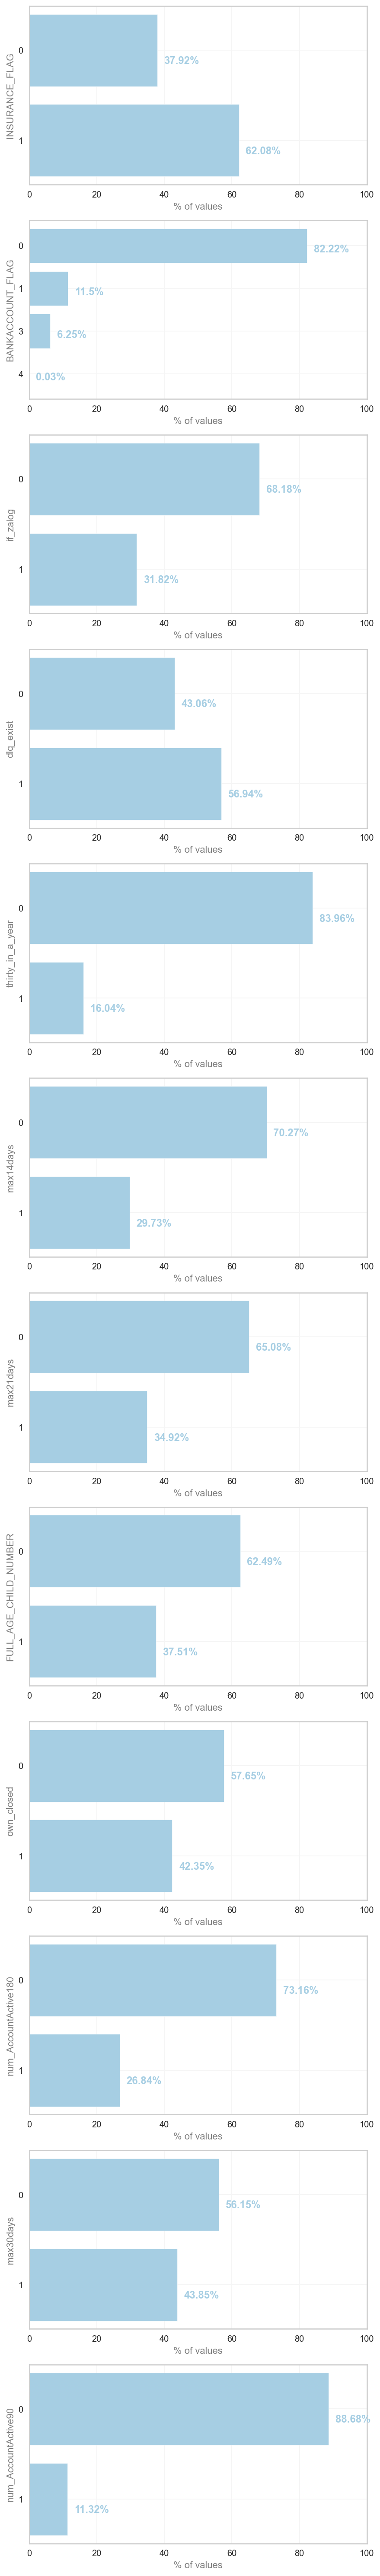

In [46]:
float_feat = (['INSURANCE_FLAG', 'BANKACCOUNT_FLAG', 'if_zalog', 'dlq_exist', 'thirty_in_a_year'] +
              new_cat + ['num_AccountActive90'])

plot_barcharts(len(float_feat), 'float', df, float_feat)

In [47]:
df['BANKACCOUNT_FLAG'] = np.where(df.BANKACCOUNT_FLAG >= 3, 1, df.BANKACCOUNT_FLAG)

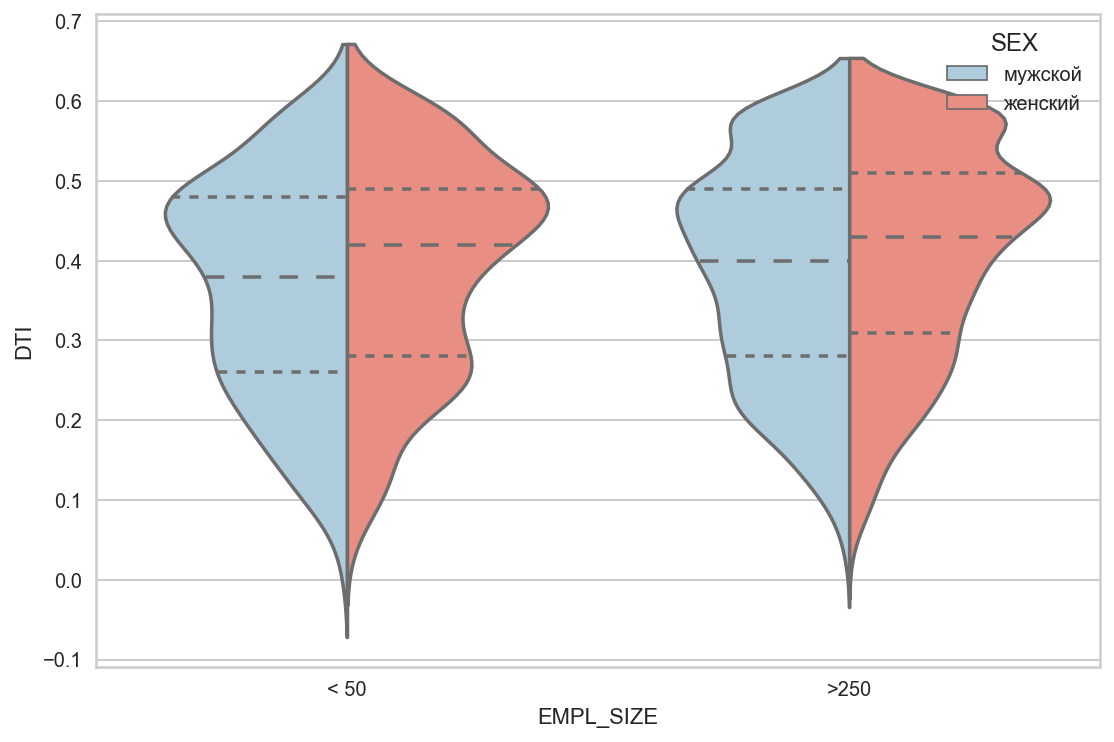

In [48]:
def plot_violins(df, x, y, hue, order):    
    plt.subplots(figsize=(9, 6))
    ax = sns.violinplot(x=x, y=y, hue=hue, data=df, order=order,
                        palette=[color, 'salmon'], split=True, inner='quartile')
    plt.show()
    
plot_violins(df, 'EMPL_SIZE', 'DTI', 'SEX', ['< 50', '>250'])

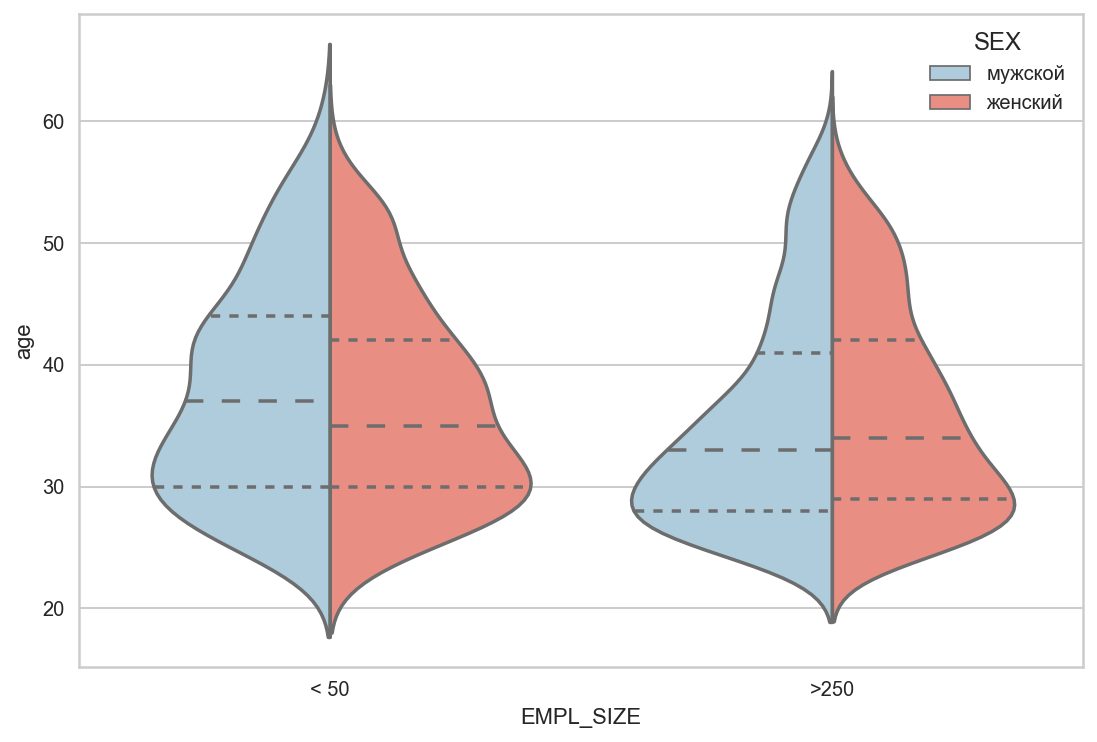

In [49]:
plot_violins(df, 'EMPL_SIZE', 'age', 'SEX', ['< 50', '>250'])

In [50]:
df.age.describe()

count    3391.000000
mean       35.951342
std         8.613548
min        23.000000
25%        29.000000
50%        34.000000
75%        42.000000
max        61.000000
Name: age, dtype: float64

In [51]:
df['age_space'] = np.where(df.age < 35, '< 35', '35+')

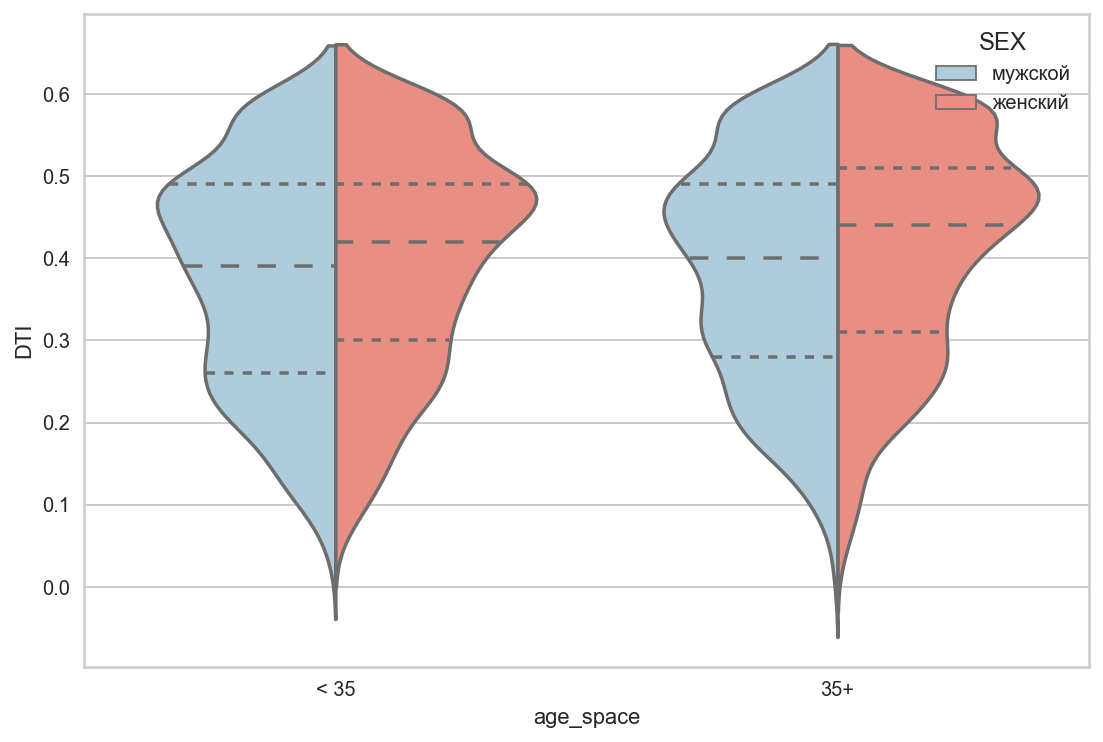

In [52]:
plot_violins(df, 'age_space', 'DTI', 'SEX', ['< 35', '35+'])

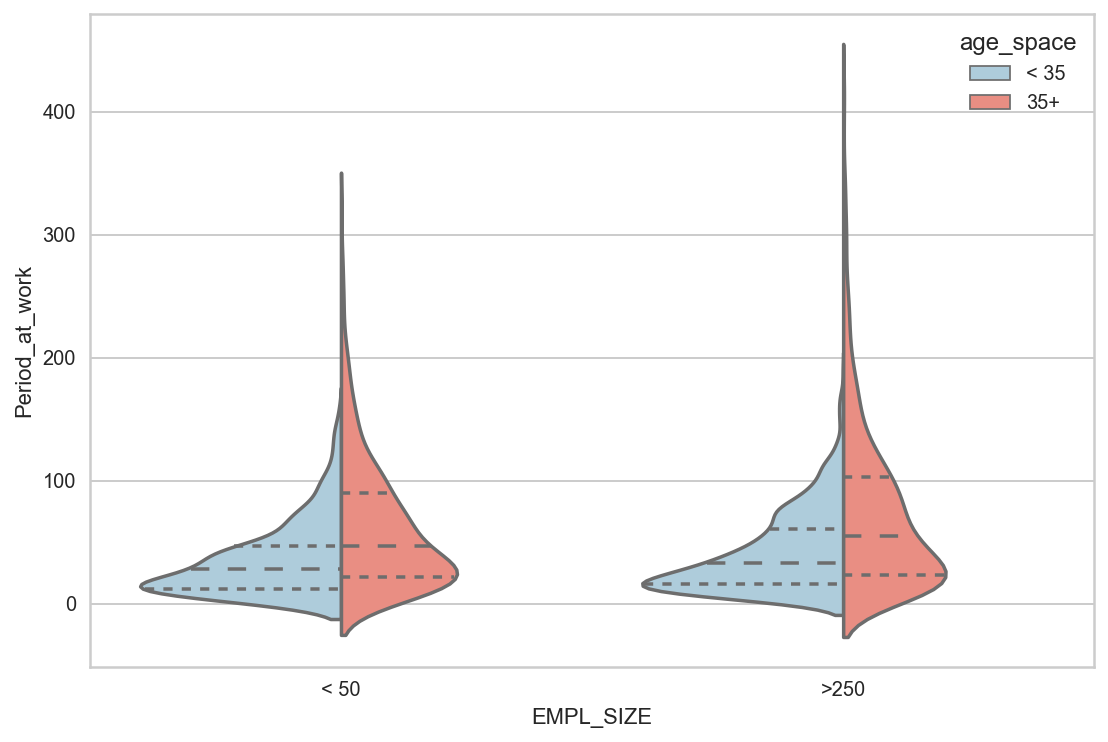

In [53]:
plot_violins(df, 'EMPL_SIZE', 'Period_at_work', 'age_space', ['< 50', '>250'])

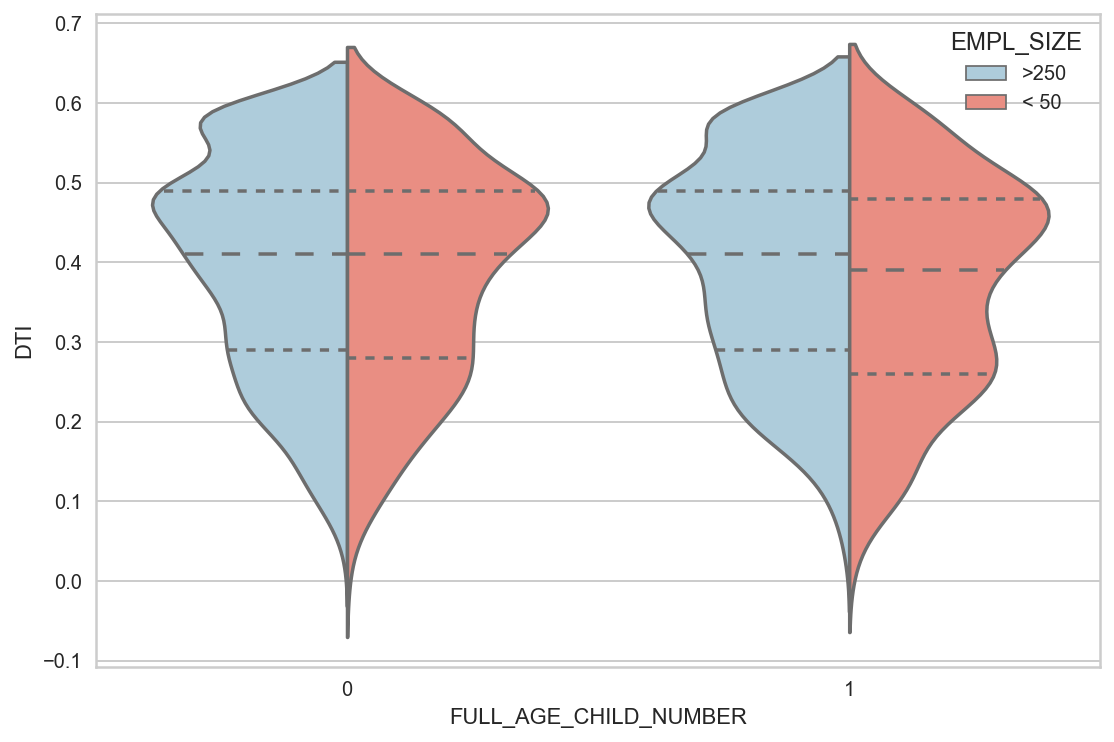

In [54]:
plot_violins(df, 'FULL_AGE_CHILD_NUMBER', 'DTI', 'EMPL_SIZE', [0, 1])

In [55]:
print('Числовых признаков:', len(num_feat))
print('Категориальных признаков:', len(cat_feat))

Числовых признаков: 14
Категориальных признаков: 21


In [56]:
describe_cat_feat(df, cat_feat)

,Уникальные значения,Число уникальных значений
EMPL_FORM,"Государственное предприятие, ЗАО, Иная форма, Индивидуальный предприниматель, ОАО, ООО",6
if_zalog,"0.0, 1.0",2
CREDIT_PURPOSE,"Другое, Нематериальные нужды, Покупка автомобиля, Покупка бытовой техники/мебели, Покупка недвижимости/земли, Ремонт",6
EMPL_PROPERTY,"Другое, Информационные технологии, Торговля",3
dlq_exist,"0.0, 1.0",2
INSURANCE_FLAG,"0.0, 1.0",2
EDUCATION,"Второе высшее/Ученая степень, высшее, незаконченное высшее, среднее, среднее-специальное",5
SEX,"женский, мужской",2
thirty_in_a_year,"0.0, 1.0",2
BANKACCOUNT_FLAG,"0.0, 1.0",2


In [57]:
describe_cat_feat(df, cat_feat)['Число уникальных значений'].sum() - len(cat_feat)

40

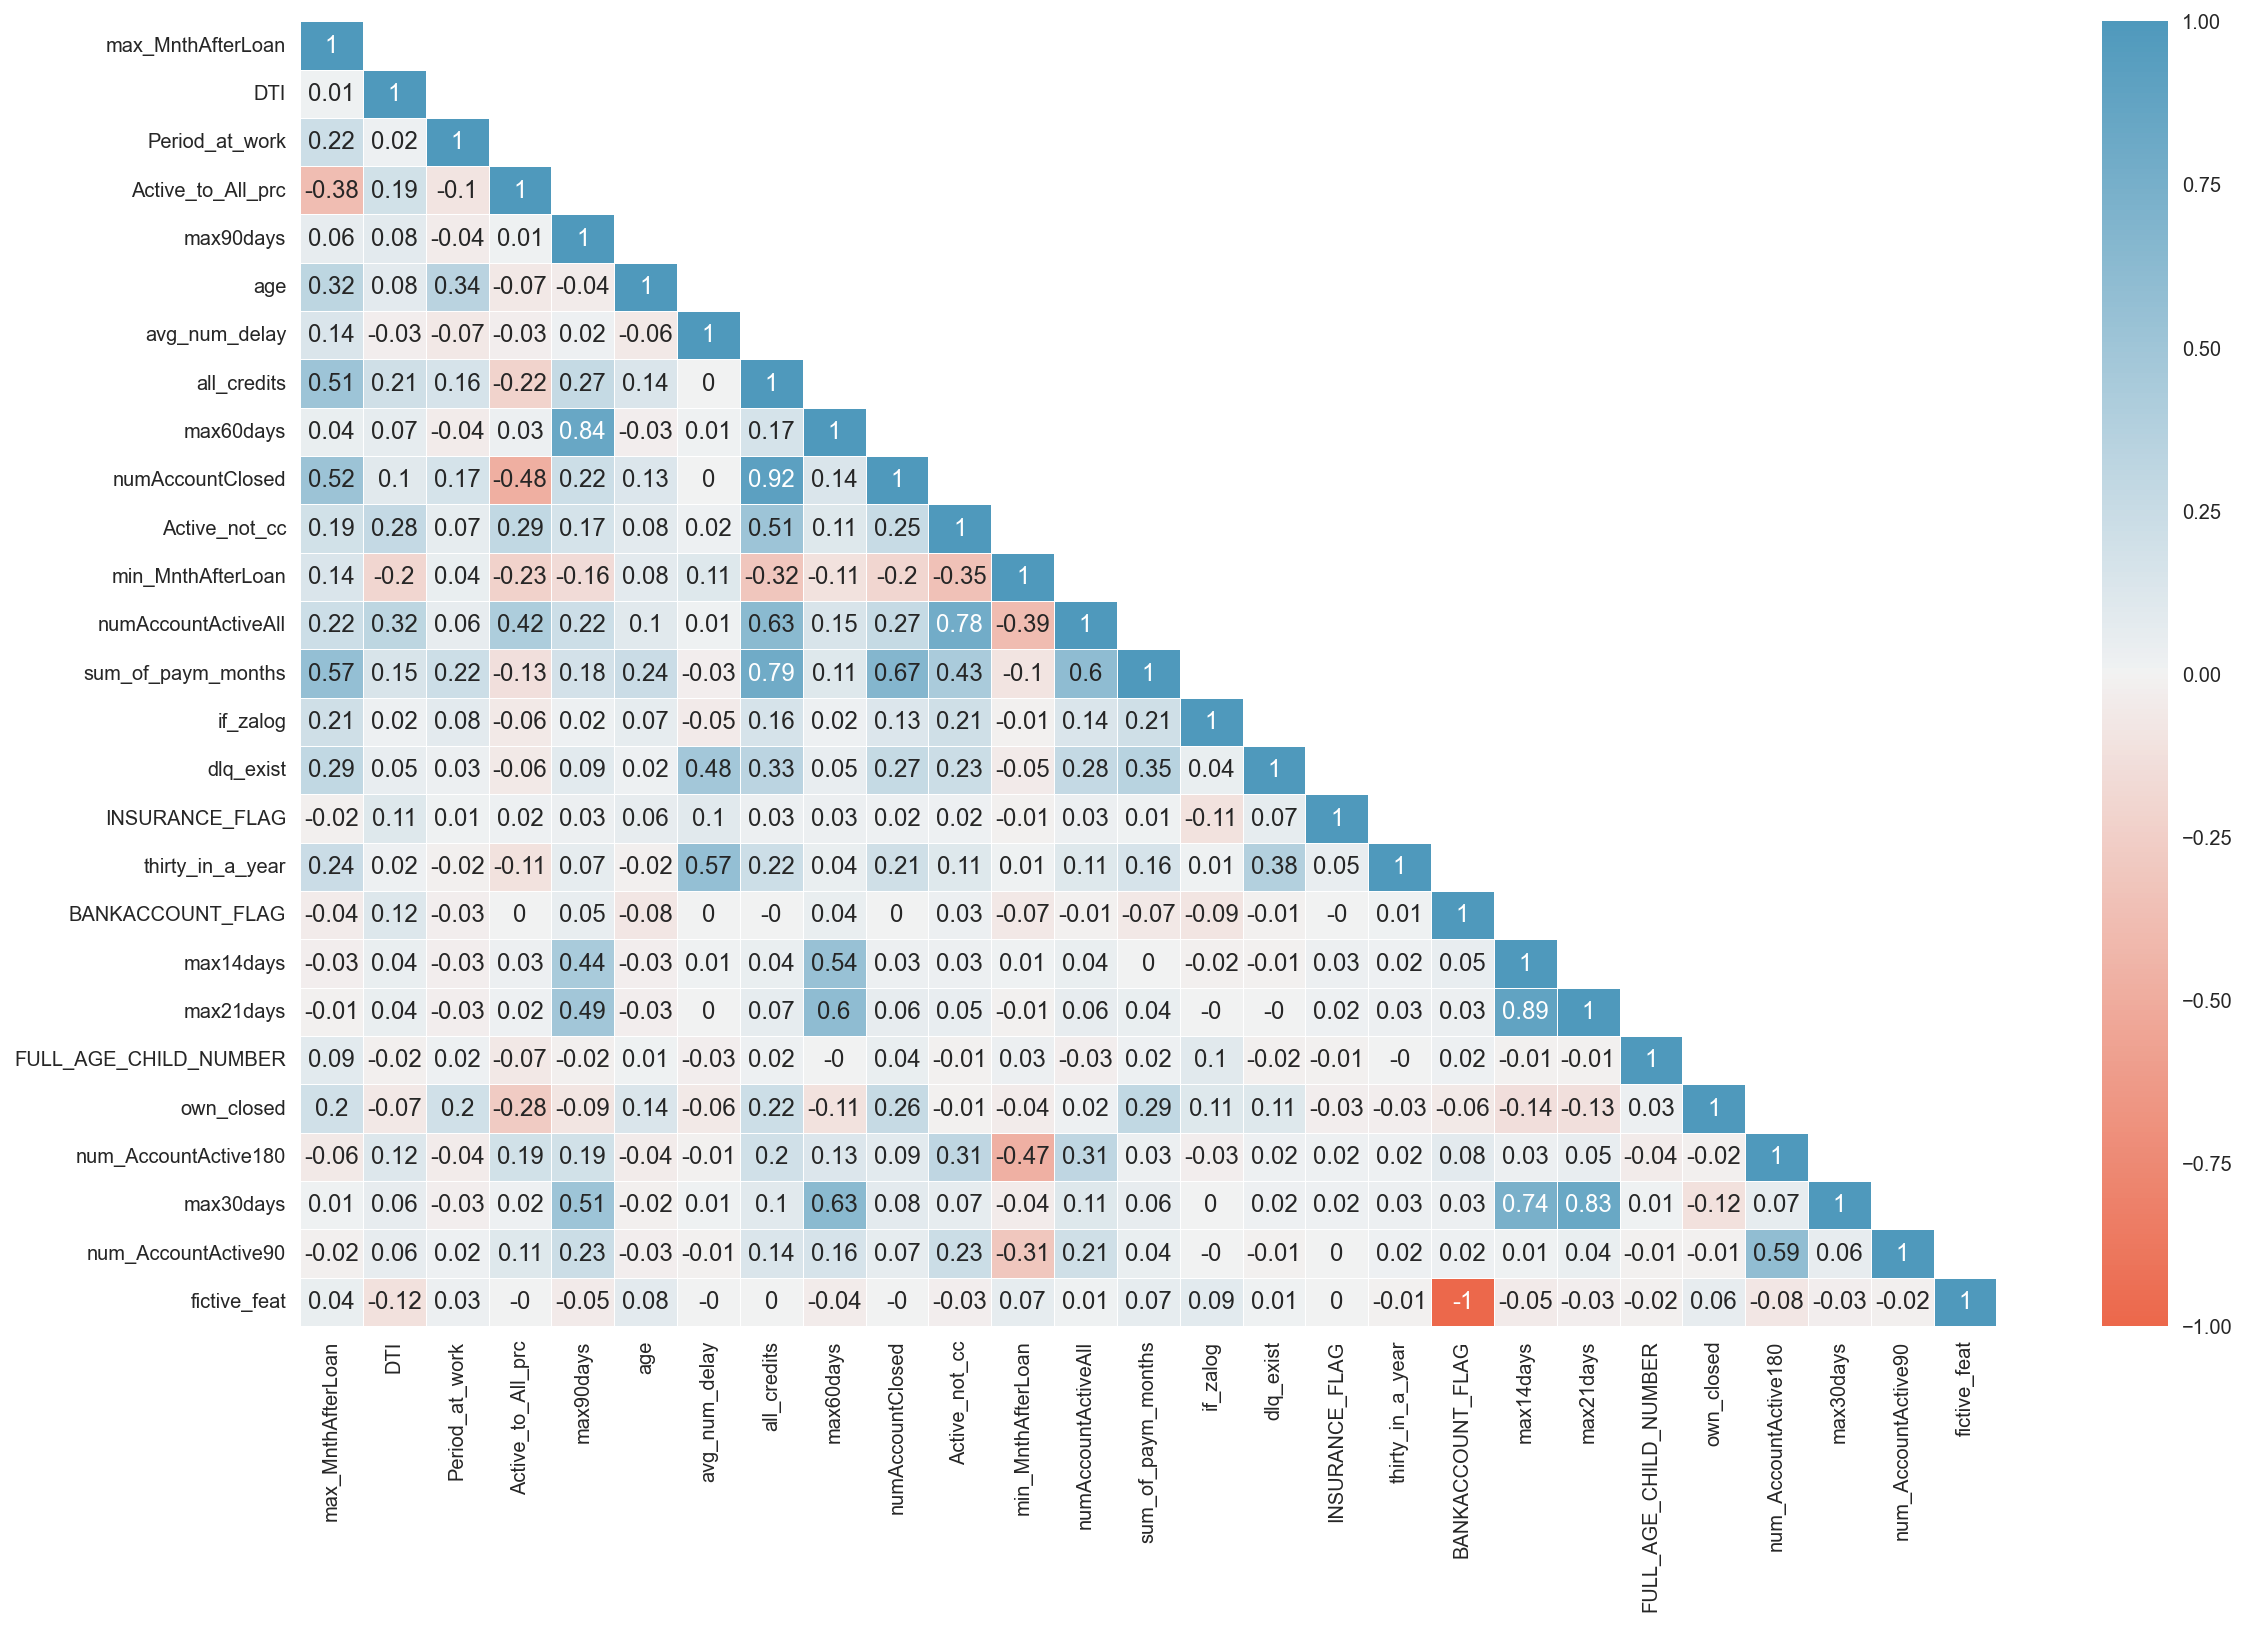

In [58]:
df['fictive_feat'] = np.where(df.BANKACCOUNT_FLAG == 1, 0, 1)

corr = np.round(df[num_feat + cat_feat + ['fictive_feat']].corr(), 2)
cmap = sns.diverging_palette(19, 230, l=60, as_cmap=True)
antimask = np.tril(np.ones((corr.shape[0], corr.shape[0])))
mask = np.absolute(antimask - np.ones((corr.shape[0], corr.shape[0])))

plt.subplots(figsize = (19, 12))
sns.heatmap(corr, mask=mask, annot=True, linewidths=.5, cmap=cmap);

In [59]:
df.drop(columns=['fictive_feat', 'age_space'], axis=1, inplace=True)
df = df.convert_dtypes()

In [60]:
def ohe_preprocess(df, feature):
    return ((pd.get_dummies(df[f'{feature}']).T).iloc[:-1]).T

In [61]:
dm = pd.concat([df[num_feat],
               df[float_feat],
               pd.concat([ohe_preprocess(df, i) for i in str_feat], axis=1)], axis=1)

In [62]:
dm.head(10)

,max_MnthAfterLoan,DTI,Period_at_work,Active_to_All_prc,max90days,age,avg_num_delay,all_credits,max60days,numAccountClosed,Active_not_cc,min_MnthAfterLoan,numAccountActiveAll,sum_of_paym_months,INSURANCE_FLAG,BANKACCOUNT_FLAG,if_zalog,dlq_exist,thirty_in_a_year,max14days,max21days,FULL_AGE_CHILD_NUMBER,own_closed,num_AccountActive180,max30days,num_AccountActive90,2НДФЛ,Поступление зарплаты на счет,Свободная форма с печатью работодателя,Другое,Нематериальные нужды,Покупка автомобиля,Покупка бытовой техники/мебели,Покупка недвижимости/земли,женский,Второе высшее/Ученая степень,высшее,незаконченное высшее,среднее,вспомогательный персонал,менеджер высшего звена,менеджер по продажам,менеджер среднего звена,рабочий,специалист,< 50,Другое,Информационные технологии,Государственное предприятие,ЗАО,Иная форма,Индивидуальный предприниматель,ОАО,женат / замужем
4,90,0.43,56,0.5,0,31,0.023333,10,0,5,1,27,5,293,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
6,80,0.46,69,0.25,0,47,0.180645,4,0,2,1,42,2,127,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
8,84,0.35,161,0.428571,1,52,0.046784,7,1,3,2,5,4,163,1,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
13,38,0.23,18,0.333333,4,28,0.03125,6,3,4,1,7,2,62,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1
16,37,0.23,45,0.0,0,23,0.0,1,0,1,0,37,0,37,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
17,46,0.19,54,0.5,6,37,0.016129,4,3,2,1,2,2,61,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
23,70,0.24,176,0.0,0,52,0.060606,2,0,1,1,41,1,31,1,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
24,70,0.59,27,0.222222,2,35,0.041667,9,2,7,1,10,2,138,0,1,1,1,1,1,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0
26,28,0.54,23,0.714286,0,33,0.0,7,0,2,3,3,5,60,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30,13,0.3,43,0.666667,1,36,0.0,3,0,1,1,4,2,15,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [63]:
dm.shape

(3391, 54)

## Сегментация методом k-means

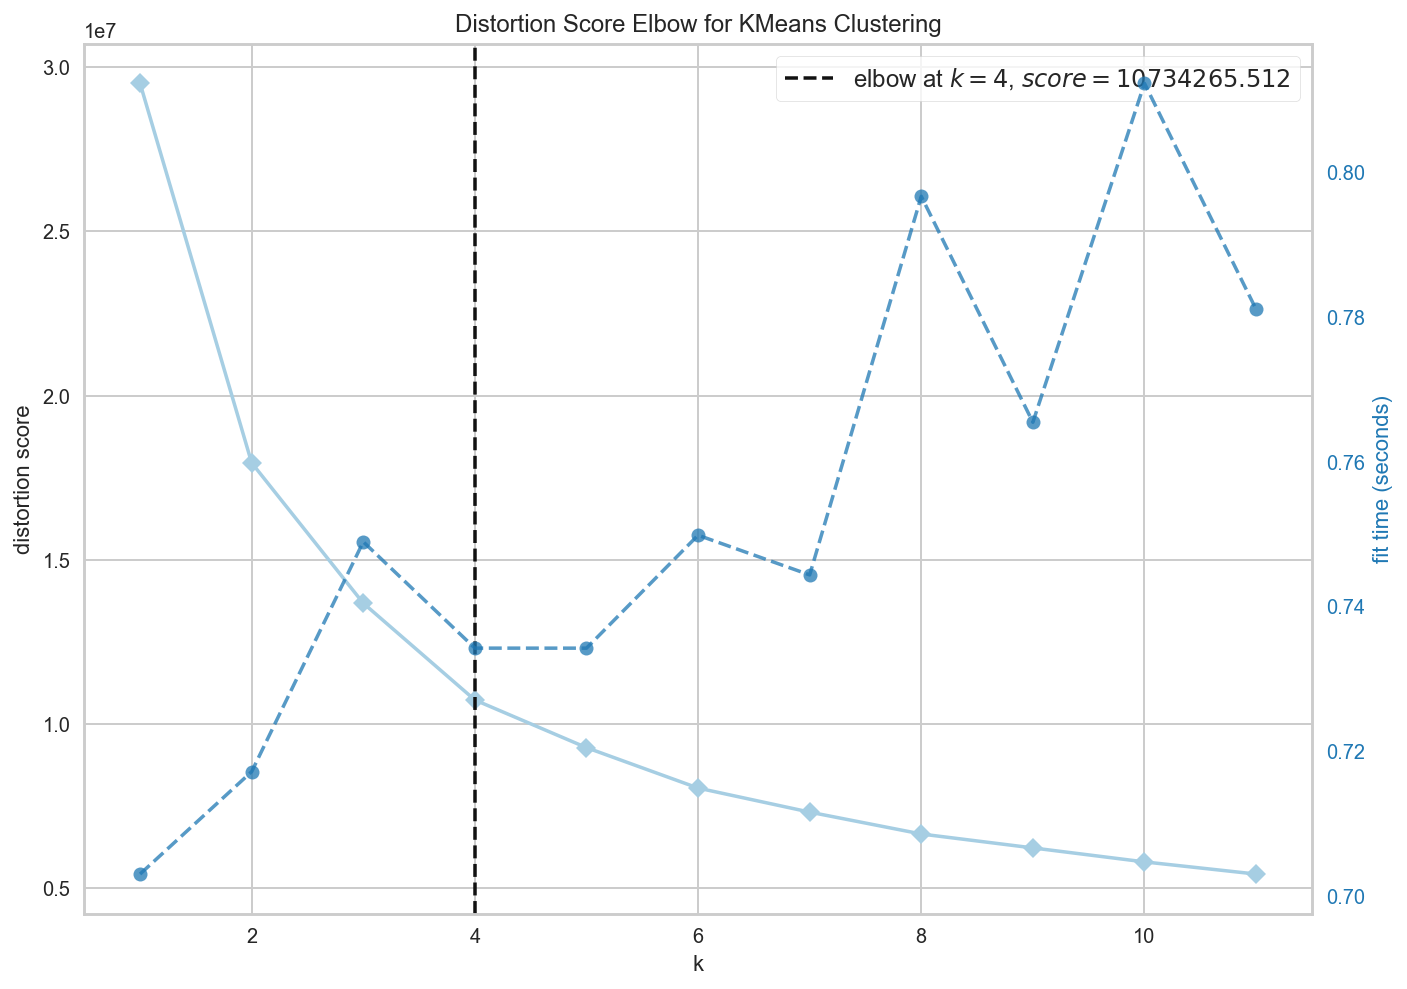

In [64]:
model = KMeans()
fig, ax = plt.subplots(figsize=(11, 8))
set_palette('paired')
visualizer = KElbowVisualizer(model, k=(1,12), ax=ax)

visualizer.fit(dm)
visualizer.show();

In [65]:
column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), num_feat)
])

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('clustering', KMeans(n_clusters=4, init='k-means++'))
])

df['cluster'] = pipeline.fit_predict(dm)

In [66]:
np.round(df.groupby('cluster').count()['all_credits'] / len(df) * 100, 2)

cluster
0    31.67
1    24.71
2    35.42
3     8.20
Name: all_credits, dtype: float64

In [67]:
print(sorted(pd.unique(df.cluster.values)))

[0, 1, 2, 3]


In [68]:
def describe_numeric(df, cluster):
    agg = df[df.cluster==cluster][num_feat].agg(['min', 'mean', 'max'])
    agg['cluster'] = np.full(len(agg), cluster)
    return agg

In [69]:
numeric = pd.concat([describe_numeric(df, i) for i in sorted(pd.unique(df.cluster.values))])
numeric['stat'] = numeric.index
numeric.set_index(['cluster', 'stat'], inplace=True)
numeric = numeric.transpose()

numeric.style.background_gradient(axis=1, cmap='Blues').format('{:.2f}')

In [70]:
def describe_cat(df, feature, compare, column):   
    cat = pd.concat([df[df[f'{feature}']==i][cat_feat+float_feat].agg(pd.Series.mode)
                     for i in sorted(pd.unique(df[f'{feature}'].values))]).T

    cat.columns = sorted(pd.unique(df[f'{feature}'].values))
    
    if feature=='cluster':
        cat['common'] = ((cat[0] == cat[1]) & (cat[1] == cat[2]) & (cat[2] == cat[3]))
    else: 
        cat['common'] = ((cat['VIP'] == cat['Дрейфующие']) & (cat['Дрейфующие'] == cat['Лояльные']) &
                         (cat['Лояльные'] == cat['Отток']) & (cat['Отток'] == cat['Риск оттока']) &
                         (cat['Риск оттока'] == cat['Спящие']))
    
    cat['index'] = cat.index
    cat.drop_duplicates(subset='index', inplace=True)

    if compare == 'common':
        return cat[cat.common == True][column]
    else:
        return cat[cat.common == False].drop(columns=['common', 'index'])

In [71]:
describe_cat(df, 'cluster', 'common', 0)

EMPL_FORM                            ООО
if_zalog                               0
CREDIT_PURPOSE                    Ремонт
EMPL_PROPERTY                   Торговля
INSURANCE_FLAG                         1
EDUCATION                         высшее
thirty_in_a_year                       0
BANKACCOUNT_FLAG                       0
EMPL_TYPE                     специалист
EMPL_SIZE                           >250
FAMILY_STATUS            женат / замужем
FULL_AGE_CHILD_NUMBER                  0
num_AccountActive180                   0
num_AccountActive90                    0
Name: 0, dtype: object

In [72]:
describe_cat(df, 'cluster', 'different', 0)

,0,1,2,3
dlq_exist,0,1,1,1
SEX,мужской,мужской,мужской,женский
INCOME_BASE_TYPE,Поступление зарплаты на счет,Форма банка (без печати работодателя),Поступление зарплаты на счет,2НДФЛ
max14days,0,0,0,1
max21days,0,0,0,1
own_closed,0,1,1,0
max30days,0,0,0,1


## RFM-сегментация

In [73]:
def get_quantiles(df, feature):
    q_33 = np.quantile(df[f'{feature}'], 0.33)
    q_66 = np.quantile(df[f'{feature}'], 0.66)
    return q_33, q_66

qr = get_quantiles(df, 'min_MnthAfterLoan')
qf = get_quantiles(df, 'all_credits')
qm = get_quantiles(df, 'sum_of_paym_months')

In [74]:
def mark_rfm(df, q, feature, label):
    df[f'{label}'] = np.where(df[f'{feature}'] < q[0], 1,
                              np.where((df[f'{feature}'] >= q[0])&(df[f'{feature}'] < q[1]), 2, 3))
    return df

qs = [qr, qf, qm]
features = ['min_MnthAfterLoan', 'all_credits', 'sum_of_paym_months']
labels = ['recency', 'frequency', 'monetary']

for i in list(zip(qs, features, labels)):
    df = mark_rfm(df, i[0], i[1], i[2])
    
df.recency = df.recency.max() + 1 - df.recency # чем меньше, тем лучше
df['rfm'] = df.recency * 100 + df.frequency * 10 + df.monetary

In [75]:
len(pd.unique(df.rfm.values))

25

In [76]:
df['segment'] = np.where(((df.rfm==111)|(df.rfm==112)|(df.rfm==113)), 'Отток',
                         
                         np.where(((df.rfm==121)|(df.rfm==122)|(df.rfm==123)|
                                   (df.rfm==131)|(df.rfm==132)|(df.rfm==133)), 'Риск оттока',
                                  
                                  np.where(((df.rfm==211)|(df.rfm==212)|(df.rfm==213)|
                                            (df.rfm==221)|(df.rfm==222)|(df.rfm==223)), 'Спящие',
                                           
                                           np.where(((df.rfm==231)|(df.rfm==311)|
                                                     (df.rfm==232)|(df.rfm==312)|
                                                     (df.rfm==233)|(df.rfm==313)), 'Дрейфующие',
                                                             
                                                             np.where(((df.rfm==321)|(df.rfm==331)|
                                                                       (df.rfm==322)|(df.rfm==332)|
                                                                       (df.rfm==323)), 'Лояльные',
                                                                      
                                                                      np.where(df.rfm==333, 'VIP', '-'))))))

In [77]:
def describe_numeric1(df, segment):
    agg = df[df.segment==segment][num_feat].agg(['min', 'mean', 'max'])
    agg['segment'] = np.full(len(agg), segment)
    return agg

numeric1 = pd.concat([describe_numeric1(df, i) for i in sorted(pd.unique(df.segment.values))])
numeric1['stat'] = numeric1.index
numeric1.set_index(['segment', 'stat'], inplace=True)
numeric1 = numeric1.transpose()

numeric1.style.background_gradient(axis=1, cmap='Blues').format('{:.2f}')

In [78]:
describe_cat(df, 'segment', 'common', 'VIP')

EMPL_FORM                            ООО
if_zalog                               0
CREDIT_PURPOSE                    Ремонт
EMPL_PROPERTY                   Торговля
INSURANCE_FLAG                         1
EDUCATION                         высшее
thirty_in_a_year                       0
BANKACCOUNT_FLAG                       0
EMPL_SIZE                           >250
FAMILY_STATUS            женат / замужем
max14days                              0
max21days                              0
FULL_AGE_CHILD_NUMBER                  0
num_AccountActive90                    0
Name: VIP, dtype: object

In [79]:
describe_cat(df, 'segment', 'different', 'VIP')

,VIP,Дрейфующие,Лояльные,Отток,Риск оттока,Спящие
dlq_exist,1,1,1,0,1,0
SEX,женский,мужской,женский,мужской,мужской,мужской
INCOME_BASE_TYPE,Форма банка (без печати работодателя),Поступление зарплаты на счет,Поступление зарплаты на счет,Поступление зарплаты на счет,Форма банка (без печати работодателя),Поступление зарплаты на счет
EMPL_TYPE,менеджер среднего звена,специалист,специалист,специалист,специалист,специалист
own_closed,1,0,0,0,0,0
num_AccountActive180,1,0,1,0,0,0
max30days,1,1,0,0,0,0
